In [359]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

class NeuralNetwork(object):
    def __init__(self):
        # Define HyperParameters
        self.inputLayerSize = 1
        self.outputLayerSize = 1
        self.hiddenLayerSize = 1

        # Weights
        self.W1 = np.random.randn(self.inputLayerSize, self.hiddenLayerSize)
        self.W2 = np.random.randn(self.hiddenLayerSize, self.outputLayerSize)
    
    def forward(self, X):
        # Propagate inputs through network
        self.z2 = np.dot(X, self.W1)        # Multiply inputs with weights
        self.a2 = self.sigmoid(self.z2)     # Hidden node function
        self.z3 = np.dot(self.a2, self.W2)  # Multiply second weights

        yH = self.sigmoid(self.z3)          # Create estimate and return
        return yH

    # Sigmoid Function
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def sigmoidPrime(self, z):
        return np.exp(-z) / (np.square(1 + np.exp(-z)))
    
    def costFunction(self, X, y):
        #Compute cost for given X,y, use weights already stored in class.
        self.yHat = self.forward(X)
        J = 0.5*sum((y-self.yHat)**2)
        return J

    def costFunctionPrime(self, X, y):
        #Compute derivative with respect to W and W2 for a given X and y:
        self.yHat = self.forward(X)
        
        delta3 = np.multiply(-(y-self.yHat), self.sigmoidPrime(self.z3))
        dJdW2 = np.dot(self.a2.T, delta3)
        
        delta2 = np.dot(delta3, self.W2.T)*self.sigmoidPrime(self.z2)
        dJdW1 = np.dot(X.T, delta2)  
        
        return dJdW1, dJdW2
    
    #Test Cost Functions
    def getParams(self):
        return np.concatenate((self.W1.ravel(), self.W2.ravel()))

    def setParams(self, params):
        W1_start = 0
        W1_end = self.hiddenLayerSize * self.inputLayerSize

        self.W1 = np.reshape(params[W1_start:W1_end], (self.inputLayerSize, self.hiddenLayerSize))

        W2_end = W1_end + self.hiddenLayerSize * self.outputLayerSize

        self.W2 = np.reshape(params[W1_end:W2_end], (self.hiddenLayerSize, self.outputLayerSize))
    
    def computeGradients(self, X, y):
        dJdW1, dJdW2 = self.costFunctionPrime(X, y)
        return np.concatenate((dJdW1.ravel(), dJdW2.ravel()))

    def computeNumericalGradient(N, X, y):
        paramsInitial = N.getParams()
        numgrad = np.zeros(paramsInitial.shape)
        perturb = np.zeros(paramsInitial.shape)
        e = 1e-4

        for p in range(len(paramsInitial)):
            perturb[p] = e
            N.setParams(paramsInitial + perturb)
            loss2 = N.costFunction(X, y)

            N.setParams(paramsInitial - perturb)
            loss1 = N.costFunction(X, y)

            numgrad[p] = (loss2 - loss1) / (2*e)

            perturb[p] = 0
        
        N.setParams(paramsInitial)
        return numgrad

#testInput = np.arange(-6, 6, 0.01)
#plt.plot(testInput, sigmoid(testInput), linewidth=2)
#plt.grid(1)

In [360]:
# Network Trainer
class Trainer(object):
    def __init__(self, N):
        #Make Local reference to network:
        self.N = N
        
    def callbackF(self, params):
        self.N.setParams(params)
        self.J.append(self.N.costFunction(self.X, self.y))   
        
    def costFunctionWrapper(self, params, X, y):
        self.N.setParams(params)
        cost = self.N.costFunction(X, y)
        grad = self.N.computeGradients(X,y)
        
        return cost, grad
        
    def train(self, X, y):
        #Make an internal variable for the callback function:
        self.X = X
        self.y = y

        #Make empty list to store costs:
        self.J = []
        
        params0 = self.N.getParams()

        options = {'maxiter': 200, 'disp' : True}
        _res = optimize.minimize(self.costFunctionWrapper, params0, jac=True, method='BFGS', \
                                 args=(X, y), options=options, callback=self.callbackF)

        self.N.setParams(_res.x)
        self.optimizationResults = _res

In [361]:
X = np.array(([7], [6], [11], [4], [9]), dtype=float)
y = np.array(([2.1336], [1.8288], [3.3528], [1.2192], [2.7432]), dtype=float)
NN = NeuralNetwork()

T = Trainer(NN)
T.train(X, y)

Optimization terminated successfully.
         Current function value: 5.297216
         Iterations: 17
         Function evaluations: 18
         Gradient evaluations: 18


Text(0.5, 0, 'Iterations')

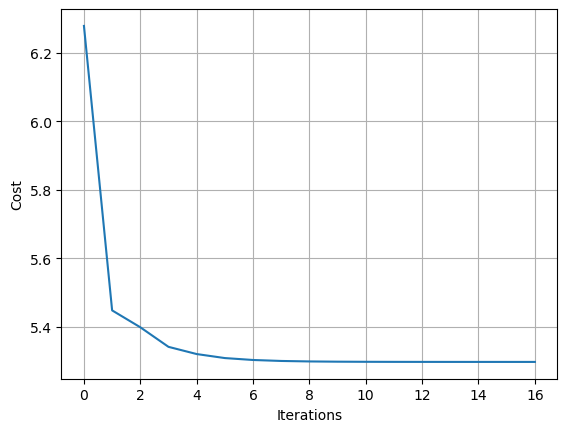

In [362]:
plt.plot(T.J)
plt.grid(1)
plt.ylabel("Cost")
plt.xlabel("Iterations")

In [363]:
NN.costFunctionPrime(X, y)

(array([[-5.24085629e-08, -5.02971498e-08]]),
 array([[-5.52834696e-06],
        [-5.52852206e-06]]))

In [364]:
print(f"Forward:\n{NN.forward(X)}\n")
print(f"y:\n{y}")

Forward:
[[0.99999912]
 [0.99999912]
 [0.99999912]
 [0.99999905]
 [0.99999912]]

y:
[[2.1336]
 [1.8288]
 [3.3528]
 [1.2192]
 [2.7432]]
